<a href="https://colab.research.google.com/github/SewoongLee/hessian_of_loss_landscape/blob/main/hessian_of_loss_landscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.0MB/s]


TinyMNISTNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
  )
  (classifier): Linear(in_feature

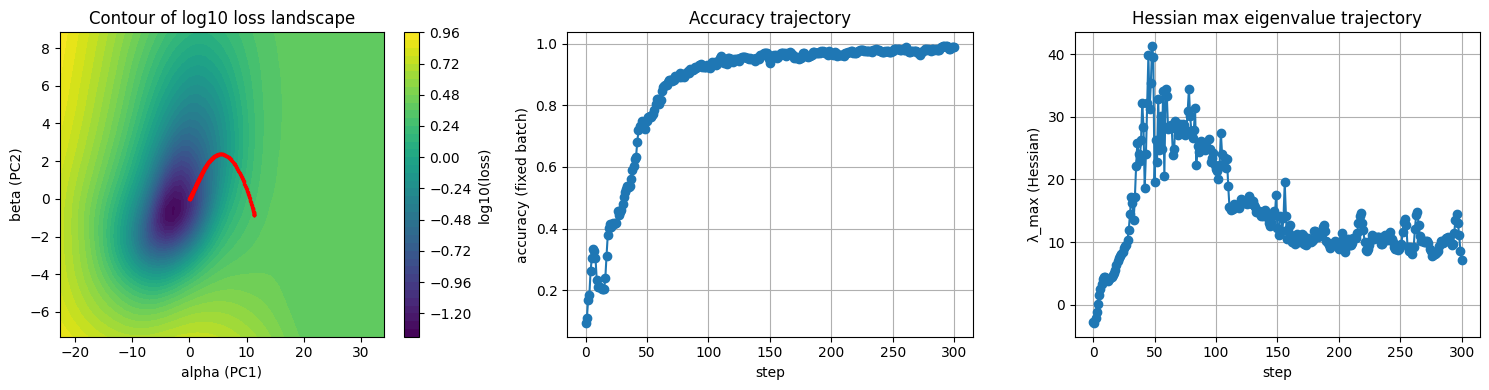

Accuracy trajectory (first 5): [0.094, 0.109, 0.168, 0.184, 0.262]
Accuracy trajectory (last 5):  [0.984, 0.984, 0.988, 0.988, 0.988]
Hessian λ_max (first 5): ['-2.792e+00', '-2.857e+00', '-2.097e+00', '-1.186e+00', '1.019e-01']
Hessian λ_max (last 5):  ['1.451e+01', '1.312e+01', '1.115e+01', '8.681e+00', '7.195e+00']


In [1]:
# ============================================
# 0. Hyperparameters & Config
# ============================================
import torch

DEVICE = "cuda"          # always use GPU
SEED = 0                 # random seed for reproducibility
SUBSET_SIZE = 8192       # number of MNIST train samples to use (out of 60000)
BATCH_SIZE = 256         # batch size for training / fixed batch
LR = 0.05                # SGD learning rate
MOMENTUM = 0.9           # SGD momentum
NUM_STEPS = 300          # number of training steps (trajectory length)
ALPHA_STEPS = 41         # resolution of loss landscape grid along alpha axis
BETA_STEPS = 41          # resolution of loss landscape grid along beta axis
MARGIN_SCALE = 2.0       # how far beyond the trajectory range to visualize in PCA plane
POWER_ITERS_INIT = 3     # number of power-iteration steps at the initial point
POWER_ITERS_PER_STEP = 1 # number of power-iteration steps per training step
EPS = 1e-8               # epsilon for numerical stability

# ============================================
# 1. Imports (rest)
# ============================================
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import plotly.graph_objects as go

# ============================================
# 2. Basic setup
# ============================================
torch.manual_seed(SEED)
device = DEVICE
print("Using device:", device)

# ============================================
# 3. Data loading (MNIST subset + fixed batch)
# ============================================
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

# use subset (set SUBSET_SIZE to 60000 or remove subset if you want full training set)
indices = list(range(SUBSET_SIZE))
subset = torch.utils.data.Subset(train_dataset, indices)
loader = torch.utils.data.DataLoader(
    subset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)

# fixed batch used for loss landscape / accuracy / Hessian computation
fixed_batch = next(iter(loader))
x_fixed, y_fixed = fixed_batch[0].to(device), fixed_batch[1].to(device)

# ============================================
# 4. Model definition: TinyMNISTNet (lightweight CNN + GAP)
# ============================================
class TinyMNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),  # (32, 14, 14)

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),  # (64, 7, 7)

            nn.Conv2d(64, 64, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(64, 10)

    def forward(self, x):
        x = self.features(x)      # (B, 64, 7, 7)
        x = x.mean(dim=(2, 3))    # global average pooling -> (B, 64)
        x = self.classifier(x)    # (B, 10)
        return x

model = TinyMNISTNet().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


# ============================================
# 5. Parameter helper functions
# ============================================
def get_params_list(model):
    return [p for p in model.parameters() if p.requires_grad]

def flatten_params(params):
    return torch.cat([p.reshape(-1) for p in params])

def unflatten_like(vec, params_template):
    outputs = []
    offset = 0
    for p in params_template:
        numel = p.numel()
        chunk = vec[offset:offset + numel].view_as(p)
        outputs.append(chunk)
        offset += numel
    return outputs

def assign_flat_params_to_model(model, flat_vec, params_template):
    new_params = unflatten_like(flat_vec, params_template)
    with torch.no_grad():
        idx = 0
        for p in model.parameters():
            if p.requires_grad:
                p.copy_(new_params[idx])
                idx += 1

def accuracy_from_logits(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

# ============================================
# 6. Hessian H v product + power iteration (approx λ_max)
# ============================================
def hvp(loss, model, v):
    """
    Compute H v (flattened).
    """
    params = get_params_list(model)
    grads = torch.autograd.grad(loss, params, create_graph=True)
    g_flat = flatten_params(grads)
    gv = torch.dot(g_flat, v)
    Hv = torch.autograd.grad(gv, params)
    Hv_flat = flatten_params(Hv).detach()
    return Hv_flat

def max_eig_power_iteration(model, x, y, criterion, v=None, num_iters=1):
    """
    Approximate λ_max via power iteration.
    If v is provided, continue from that vector.
    """
    params = get_params_list(model)
    num_params = sum(p.numel() for p in params)

    if v is None or v.numel() != num_params:
        v = torch.randn(num_params, device=device)
        v = v / (v.norm() + EPS)

    lambda_est = None
    for _ in range(num_iters):
        logits = model(x)
        loss = criterion(logits, y)

        Hv = hvp(loss, model, v)
        lambda_est = torch.dot(v, Hv) / (torch.dot(v, v) + EPS)
        v = Hv / (Hv.norm() + EPS)

    return lambda_est.item(), v

# ============================================
# 7. Training and recording parameter / loss / accuracy / Hessian trajectories
# ============================================
params_template = get_params_list(model)
theta_init = flatten_params(params_template).detach()

theta_traj = []      # parameter vector trajectory
loss_traj = []       # fixed-batch loss trajectory
acc_traj = []        # fixed-batch accuracy trajectory
hessian_traj = []    # λ_max(H) trajectory
power_v = None       # vector used in power iteration

# initial state (on fixed batch)
model.train()
with torch.no_grad():
    logits0 = model(x_fixed)
    loss0 = criterion(logits0, y_fixed)
    acc0 = accuracy_from_logits(logits0, y_fixed)

theta_traj.append(theta_init)
loss_traj.append(loss0.item())
acc_traj.append(acc0)

# Hessian sharpness at the initial point
lambda0, power_v = max_eig_power_iteration(
    model, x_fixed, y_fixed, criterion,
    v=power_v, num_iters=POWER_ITERS_INIT
)
hessian_traj.append(lambda0)

print(f"Step 0 | loss={loss0.item():.4f}, acc={acc0:.4f}, λ_max={lambda0:.3e}")

data_iter = iter(loader)

for step in range(1, NUM_STEPS + 1):
    try:
        xb, yb = next(data_iter)
    except StopIteration:
        data_iter = iter(loader)
        xb, yb = next(data_iter)

    xb, yb = xb.to(device), yb.to(device)

    # 1) training step
    optimizer.zero_grad()
    logits = model(xb)
    loss = criterion(logits, yb)
    loss.backward()
    optimizer.step()

    # 2) store current parameters
    theta_cur = flatten_params(get_params_list(model)).detach()
    theta_traj.append(theta_cur)

    # 3) evaluate loss & accuracy on fixed batch
    with torch.no_grad():
        logits_fixed = model(x_fixed)
        loss_fixed = criterion(logits_fixed, y_fixed)
        acc_fixed = accuracy_from_logits(logits_fixed, y_fixed)

    loss_traj.append(loss_fixed.item())
    acc_traj.append(acc_fixed)

    # 4) evaluate Hessian sharpness on fixed batch
    lambda_k, power_v = max_eig_power_iteration(
        model, x_fixed, y_fixed, criterion,
        v=power_v, num_iters=POWER_ITERS_PER_STEP
    )
    hessian_traj.append(lambda_k)

    if step % 20 == 0 or step == NUM_STEPS:
        print(f"Step {step:3d} | loss={loss_fixed.item():.4f}, acc={acc_fixed:.4f}, λ_max={lambda_k:.3e}")

print(f"Collected {len(theta_traj)} trajectory points.")

theta_ref = flatten_params(get_params_list(model)).detach()
num_params = theta_ref.numel()
print("Number of parameters:", num_params)
print(f"Initial accuracy (fixed batch): {acc_traj[0]:.3f}")
print(f"Final   accuracy (fixed batch): {acc_traj[-1]:.3f}")
print(f"Hessian λ_max: min={min(hessian_traj):.3e}, max={max(hessian_traj):.3e}")

# ============================================
# 8. Compute d1, d2 via PCA (SVD) on trajectory
# ============================================
theta_mat = torch.stack(theta_traj, dim=0).to(device)  # [T, D]
T, D = theta_mat.shape
print("Trajectory matrix shape:", theta_mat.shape)

theta_mean = theta_mat.mean(dim=0, keepdim=True)
theta_centered = theta_mat - theta_mean

U, S, Vh = torch.linalg.svd(theta_centered, full_matrices=False)
V = Vh.transpose(0, 1)  # [D, k]

d1 = V[:, 0]
d2 = V[:, 1]

d1 = d1 / (d1.norm() + EPS)
d2 = d2 - torch.dot(d1, d2) * d1
d2 = d2 / (d2.norm() + EPS)

# ============================================
# 9. Project trajectory onto PCA plane (alpha, beta)
# ============================================
alphas = []
betas = []

for theta_t in theta_traj:
    delta = theta_t.to(device) - theta_ref
    alpha_t = torch.dot(delta, d1).item()
    beta_t  = torch.dot(delta, d2).item()
    alphas.append(alpha_t)
    betas.append(beta_t)

alpha_min, alpha_max = min(alphas), max(alphas)
beta_min,  beta_max  = min(betas),  max(betas)

alpha_range = alpha_max - alpha_min + EPS
beta_range  = beta_max - beta_min + EPS
margin_a = MARGIN_SCALE * alpha_range
margin_b = MARGIN_SCALE * beta_range

alpha_min_plot = alpha_min - margin_a
alpha_max_plot = alpha_max + margin_a
beta_min_plot  = beta_min  - margin_b
beta_max_plot  = beta_max  + margin_b

print("alpha range:", alpha_min_plot, alpha_max_plot)
print("beta range :", beta_min_plot, beta_max_plot)

# ============================================
# 10. Compute log-loss surface on PCA plane
# ============================================
alpha_vals = torch.linspace(alpha_min_plot, alpha_max_plot, ALPHA_STEPS, device=device)
beta_vals  = torch.linspace(beta_min_plot,  beta_max_plot,  BETA_STEPS,  device=device)

loss_surface = torch.zeros(ALPHA_STEPS, BETA_STEPS, device=device)

for i, a in enumerate(alpha_vals):
    for j, b in enumerate(beta_vals):
        theta_ab = theta_ref + a * d1 + b * d2
        assign_flat_params_to_model(model, theta_ab, params_template)

        logits = model(x_fixed)
        loss = criterion(logits, y_fixed)
        loss_surface[i, j] = loss.detach()

# restore θ_ref
assign_flat_params_to_model(model, theta_ref, params_template)

# ============================================
# 11. Compute log-loss along projected trajectory on PCA plane
# ============================================
proj_loss_traj = []
for a, b in zip(alphas, betas):
    a_t = torch.tensor(a, device=device, dtype=torch.float32)
    b_t = torch.tensor(b, device=device, dtype=torch.float32)
    theta_ab = theta_ref + a_t * d1 + b_t * d2
    assign_flat_params_to_model(model, theta_ab, params_template)

    logits = model(x_fixed)
    loss = criterion(logits, y_fixed)
    proj_loss_traj.append(loss.item())

# restore θ_ref again
assign_flat_params_to_model(model, theta_ref, params_template)

loss_surface_log = torch.log10(loss_surface + EPS)
proj_loss_traj_log = torch.log10(torch.tensor(proj_loss_traj) + EPS)

# move to CPU for plotting
alpha_vals_cpu = alpha_vals.cpu()
beta_vals_cpu  = beta_vals.cpu()
A_cpu, B_cpu = torch.meshgrid(alpha_vals_cpu, beta_vals_cpu, indexing="ij")
Z_cpu = loss_surface_log.cpu()

alphas_cpu = torch.tensor(alphas)
betas_cpu  = torch.tensor(betas)
proj_loss_traj_cpu = proj_loss_traj_log.cpu()

# ============================================
# 12. 3D plot: Plotly surface + trajectory
# ============================================
fig3d = go.Figure()

fig3d.add_surface(
    x=A_cpu.numpy(),
    y=B_cpu.numpy(),
    z=Z_cpu.numpy(),
    opacity=0.8,
    showscale=True,
)

fig3d.add_trace(
    go.Scatter3d(
        x=alphas_cpu.numpy(),
        y=betas_cpu.numpy(),
        z=proj_loss_traj_cpu.numpy(),
        mode="lines+markers",
        line=dict(width=5, color="red"),
        marker=dict(size=3, color="red"),
        name="trajectory",
    )
)

fig3d.update_layout(
    title="TinyMNISTNet: log10 loss landscape with training trajectory",
    scene=dict(
        xaxis_title="alpha (PC1)",
        yaxis_title="beta (PC2)",
        zaxis_title="log10(loss)",
    ),
    width=800,
    height=600,
)
fig3d.show()

# ============================================
# 13. 2D contour + accuracy + Hessian λ_max trajectories
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# (1) Contour
ax2 = axes[0]
cont = ax2.contourf(A_cpu.numpy(), B_cpu.numpy(), Z_cpu.numpy(), levels=40)
ax2.plot(alphas_cpu.numpy(), betas_cpu.numpy(), "r.-", linewidth=2, markersize=3)
ax2.set_xlabel("alpha (PC1)")
ax2.set_ylabel("beta (PC2)")
ax2.set_title("Contour of log10 loss landscape")
cbar = plt.colorbar(cont, ax=ax2)
cbar.set_label("log10(loss)")

# (2) Accuracy trajectory
ax3 = axes[1]
steps = list(range(len(acc_traj)))
ax3.plot(steps, acc_traj, marker="o")
ax3.set_xlabel("step")
ax3.set_ylabel("accuracy (fixed batch)")
ax3.set_title("Accuracy trajectory")
ax3.grid(True)

# (3) Hessian λ_max trajectory
ax4 = axes[2]
ax4.plot(range(len(hessian_traj)), hessian_traj, marker="o")
ax4.set_xlabel("step")
ax4.set_ylabel("λ_max (Hessian)")
ax4.set_title("Hessian max eigenvalue trajectory")
ax4.grid(True)

plt.tight_layout()
plt.show()

print(f"Accuracy trajectory (first 5): {[round(a,3) for a in acc_traj[:5]]}")
print(f"Accuracy trajectory (last 5):  {[round(a,3) for a in acc_traj[-5:]]}")
print(f"Hessian λ_max (first 5): {[f'{v:.3e}' for v in hessian_traj[:5]]}")
print(f"Hessian λ_max (last 5):  {[f'{v:.3e}' for v in hessian_traj[-5:]]}")
